# Method 1. LDA

# Part 1. Prepare model

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import TfidfModel, LdaModel, LdaMulticore, CoherenceModel
from gensim.corpora import Dictionary
from gensim.matutils import corpus2csc
from gensim.similarities import MatrixSimilarity
import numpy as np
from pyspark.sql import SparkSession
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import pandas as pd
import pyLDAvis.gensim

In [2]:
%run -i 'ETL/spark_etl.py'

2020-05-19 17:33:25.702379: Entry point to ETL
2020-05-19 17:33:41.181227: ETL started
+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|120401325X| [0, 0]|    5.0|Came just as desc...|08 22, 2013|A1JVVYYO7G56DS|         Tyler Evans|   best thing ever..|    1377129600|
|8288862993| [0, 0]|    1.0|JUNK!!!......This...| 08 4, 2013| A3YHN4DKZS7WN|              Boiram|                FAIL|    1375574400|
|8288862993| [0, 0]|    5.0|I use this charge...|03 19, 2013|A1718L78QHNDXV|  M. Paul "Realnews"|   Works as expected|    1363651200|
|9983798883| [0, 0]|    5.0|The Motorola T505...| 11 6, 2011|A2EUP9822U2RAH|                 PTR|      Great 

In [3]:
random = 42
# in_col = 'doc'
in_col = 'lemmas'
lda_num_topics = 20
no_below_filter = 15 # absolute
no_above_filter = 0.7 # fraction
dupl_threshold = 0.98

lda_model_path = './lda_model'
lda_dict_path = './lda_dict'
lda_corp_path = './lda_corp'
df_path = './df_spark'

## Initialize and read data

In [5]:
spark = SparkSession.builder.appName("cradar").getOrCreate()

df = spark.read.parquet(df_path)

(train, test) = df.randomSplit([0.9, 0.1], seed=random)

train_col = [line.in_col for line in train.selectExpr(f'{in_col} as in_col').collect()]
test_col = [line.in_col for line in test.selectExpr(f'{in_col} as in_col').collect()]

print('Train count', len(train_col))
print('Test count', len(test_col))

Train count 17990
Test count 1968


## Optimize LDA number of topics

In [6]:
dct = Dictionary(train_col)
print('Term dictionary count', len(dct))
dct.filter_extremes(no_below=no_below_filter, no_above=no_above_filter)
print('No extremes term dictionary count', len(dct))
corpus = [dct.doc2bow(line) for line in train_col]

# parameter space
nums_topics = [2, 5, 7, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 500, 750, 1000]
coherences = {}
for num_topics_ in nums_topics:
    print(f'Training LDA for {num_topics_} topics')
    lda = LdaModel(corpus, num_topics=num_topics_, id2word=dct, random_state=random)
    cm = CoherenceModel(model=lda, corpus=corpus, dictionary=dct, coherence='u_mass')
    print('Coherence:', cm.get_coherence())
    coherences[num_topics_] = cm.get_coherence()

Term dictionary count 23640
No extremes term dictionary count 3894
Training LDA for 2 topics
Coherence: -1.8372017029615644
Training LDA for 5 topics
Coherence: -1.826541236756384
Training LDA for 7 topics
Coherence: -1.8886135119272176
Training LDA for 10 topics
Coherence: -2.1002263381073085
Training LDA for 20 topics
Coherence: -2.2296181816136675
Training LDA for 30 topics
Coherence: -2.6608146846862315
Training LDA for 50 topics
Coherence: -3.2487404304767695
Training LDA for 75 topics
Coherence: -3.989197141336916
Training LDA for 100 topics
Coherence: -4.673908641192869
Training LDA for 150 topics
Coherence: -4.961703562417893
Training LDA for 200 topics
Coherence: -5.2713288923138135
Training LDA for 250 topics
Coherence: -4.8821569515201135
Training LDA for 300 topics
Coherence: -4.363244552837482
Training LDA for 500 topics
Coherence: -3.1924283909172435
Training LDA for 750 topics
Coherence: -4.126724480090519
Training LDA for 1000 topics
Coherence: -5.521436342850841


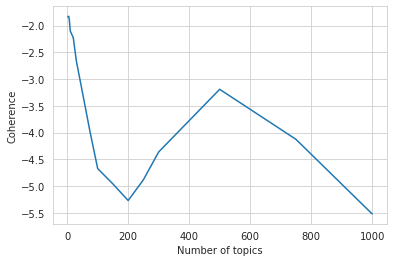

In [7]:
# Dependence of topic coherence from number of topics
sns.set_style('whitegrid')
plt.plot(list(coherences.keys()), list(coherences.values()))
plt.ylabel('Coherence')
plt.xlabel('Number of topics')
plt.show()

In [8]:
dct = Dictionary(train_col)
print('Term dictionary count', len(dct))
dct.filter_extremes(no_below=no_below_filter, no_above=no_above_filter)
print('No extremes term dictionary count', len(dct))
corpus = [dct.doc2bow(line) for line in train_col]

# parameter space
nums_topics = [1, 2, 5, 10, 15, 20, 25, 30, 40, 50]
coherences = {}
for num_topics_ in nums_topics:
    print(f'Training LDA for {num_topics_} topics')
    lda = LdaModel(corpus, num_topics=num_topics_, id2word=dct, random_state=random)
    cm = CoherenceModel(model=lda, corpus=corpus, dictionary=dct, coherence='u_mass')
    print('Coherence:', cm.get_coherence())
    coherences[num_topics_] = cm.get_coherence()

Term dictionary count 23640
No extremes term dictionary count 3894
Training LDA for 1 topics
Coherence: -1.6379341647635155
Training LDA for 2 topics
Coherence: -1.8372017029615644
Training LDA for 5 topics
Coherence: -1.826541236756384
Training LDA for 10 topics
Coherence: -2.1002263381073085
Training LDA for 15 topics
Coherence: -2.1796322856740273
Training LDA for 20 topics
Coherence: -2.2296181816136675
Training LDA for 25 topics
Coherence: -2.4127080018677187
Training LDA for 30 topics
Coherence: -2.6608146846862315
Training LDA for 40 topics
Coherence: -2.9710459216767444
Training LDA for 50 topics
Coherence: -3.2487404304767695


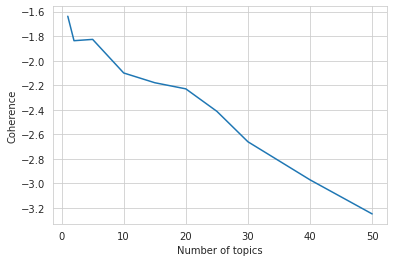

In [9]:
# Dependence of topic coherence from number of topics
sns.set_style('whitegrid')
plt.plot(list(coherences.keys()), list(coherences.values()))
plt.ylabel('Coherence')
plt.xlabel('Number of topics')
plt.show()

## Fit LDA

In [15]:
dct = Dictionary(train_col)
print('Term dictionary count', len(dct))
dct.filter_extremes(no_below=no_below_filter, no_above=no_above_filter)
print('No extremes term dictionary count', len(dct))

corpus = [dct.doc2bow(line) for line in train_col]

lda_model = LdaModel(corpus, 
                     num_topics=lda_num_topics, 
                     id2word=dct, 
                     random_state=random,
                     alpha='symmetric',
                     per_word_topics=True)

cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dct, coherence='u_mass')    

Term dictionary count 23640
No extremes term dictionary count 3894


## Persist LDA

In [11]:
lda.save(lda_model_path)
with open(lda_dict_path, 'wb') as fp:
    pickle.dump(dct, fp)
fp.close()
with open(lda_corp_path, 'wb') as fp:
    pickle.dump(corpus, fp)
fp.close()

# Part 2. Apply model


## Read LDA

In [12]:
lda_model = LdaModel.load(lda_model_path)
with open(lda_dict_path, 'rb') as fp:
    dct = pickle.load(fp)
    fp.close()
with open(lda_corp_path, 'rb') as fp:
    corpus = pickle.load(fp)
    fp.close()

## LDA dominant topics

In [16]:
print('LDA topics')
lda_model.print_topics(lda_num_topics, num_words=7)

LDA topics


[(0,
  '0.017*"tool" + 0.016*"good" + 0.011*"work" + 0.010*"set" + 0.009*"sound" + 0.008*"use" + 0.008*"well"'),
 (1,
  '0.029*"fit" + 0.024*"great" + 0.021*"size" + 0.019*"wear" + 0.019*"look" + 0.018*"love" + 0.014*"good"'),
 (2,
  '0.031*"dog" + 0.018*"saw" + 0.017*"blade" + 0.017*"great" + 0.015*"size" + 0.012*"one" + 0.010*"small"'),
 (3,
  '0.023*"one" + 0.018*"product" + 0.015*"protector" + 0.015*"screen" + 0.012*"would" + 0.012*"pump" + 0.011*"work"'),
 (4,
  '0.022*"bra" + 0.019*"shirt" + 0.019*"wash" + 0.018*"well" + 0.015*"soft" + 0.015*"material" + 0.011*"pad"'),
 (5,
  '0.019*"use" + 0.015*"stroller" + 0.013*"well" + 0.012*"work" + 0.012*"diaper" + 0.011*"easy" + 0.009*"handle"'),
 (6,
  '0.054*"toy" + 0.023*"like" + 0.019*"love" + 0.017*"bag" + 0.011*"one" + 0.011*"play" + 0.010*"dog"'),
 (7,
  '0.043*"baby" + 0.024*"one" + 0.020*"love" + 0.019*"month" + 0.012*"great" + 0.012*"son" + 0.010*"old"'),
 (8,
  '0.013*"unit" + 0.011*"device" + 0.011*"work" + 0.010*"one" + 0.010

In [17]:
def topics_per_document(model, corpus):
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

In [21]:
# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(num_topics=lda_num_topics, formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

## Plot dominant topics 

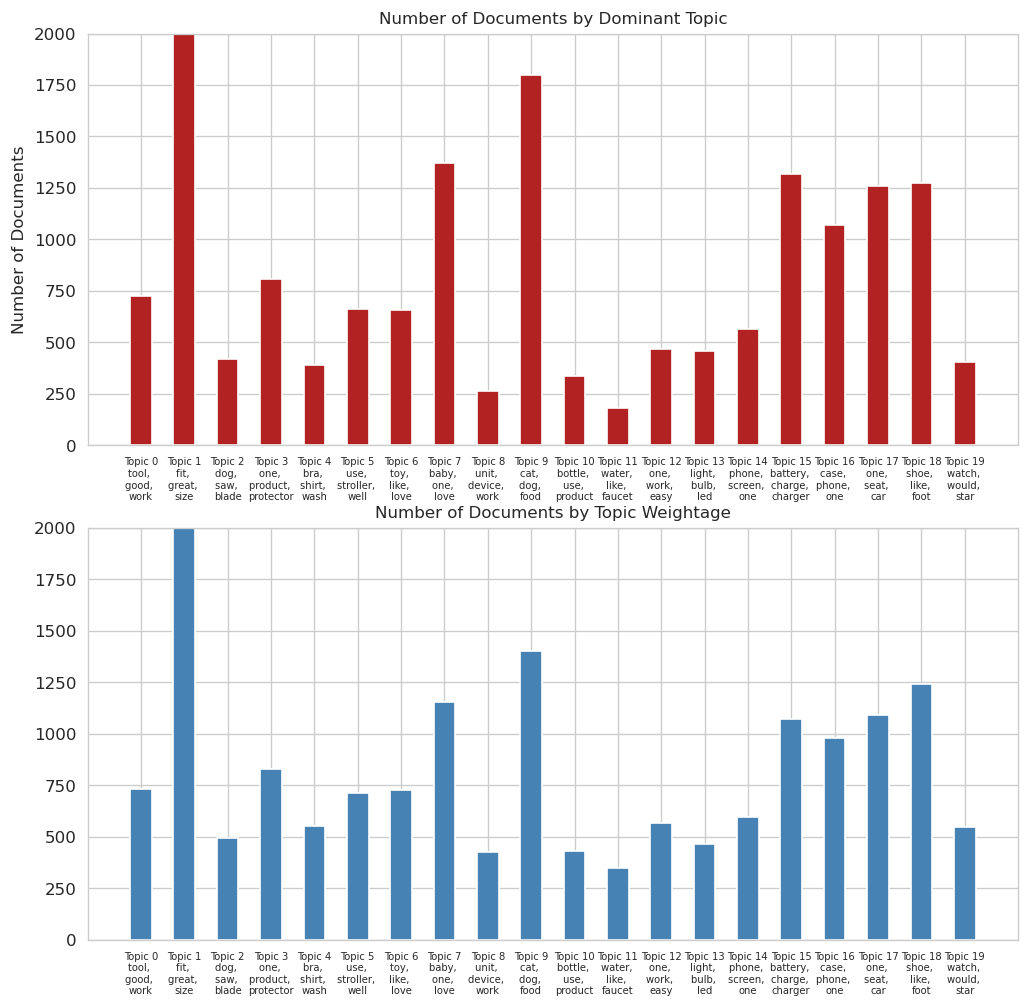

In [19]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 2000)
ax1.tick_params(axis="x", labelsize=6)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
ax2.tick_params(axis="x", labelsize=6)

plt.show()

## Interactive LDA visualization and analysis

In [20]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.143023 -0.092851       1        1  9.736783
15    -0.136297 -0.043374       2        1  9.173569
17     0.033981  0.043660       3        1  8.271239
9      0.058755  0.105602       4        1  8.131485
18     0.087692 -0.074407       5        1  7.414322
7      0.076440  0.019565       6        1  6.278290
0     -0.077570  0.025259       7        1  5.811845
16    -0.023606 -0.115747       8        1  5.659678
5     -0.015154  0.046912       9        1  4.637051
3     -0.018218 -0.044221      10        1  4.464283
14    -0.062435 -0.100210      11        1  4.129015
12    -0.042141  0.002773      12        1  3.782715
8     -0.125657  0.005240      13        1  3.427579
13    -0.088444  0.000898      14        1  3.262948
6      0.114576  0.079607      15        1  3.242724
19     0.012300 -0.059313      16        1  2.863067
4      0.127967 -0.056102      17        1  2.674613
2      0.059915  0.124509      18        1  2.589523
10    -0.096059  0.095381      19        1  2.304901
11    -0.029068  0.036821      20        1  2.144371, topic_info=       Term         Freq        Total Category  logprob  loglift
310    case  3762.000000  3762.000000  Default  30.0000  30.0000
454   phone  3962.000000  3962.000000  Default  29.0000  29.0000
135   light  2791.000000  2791.000000  Default  28.0000  28.0000
1261    dog  2600.000000  2600.000000  Default  27.0000  27.0000
931     cat  1939.000000  1939.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
804   since    66.004364  1407.445312  Topic20  -5.3927   0.7825
500    easy    68.158585  2598.575684  Topic20  -5.3606   0.2014
750   month    66.258400  1843.638428  Topic20  -5.3889   0.5164
4      also    66.722900  3423.064941  Topic20  -5.3819  -0.0954
94      get    63.648884  4886.454102  Topic20  -5.4290  -0.4985

[1540 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3670      5  0.121872  accurately
3670     16  0.853103  accurately
2266      4  0.115633         act
2266      7  0.099114         act
2266      9  0.099114         act
...     ...       ...         ...
2219      7  0.054233     youtube
2219     11  0.777339     youtube
2219     15  0.018078     youtube
2219     17  0.018078     youtube
2372     15  0.893777      zipped

[7288 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 16, 18, 10, 19, 8, 1, 17, 6, 4, 15, 13, 9, 14, 7, 20, 5, 3, 11, 12])